In [1]:
%autoreload 2
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random
from tqdm import tqdm

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteMap, FiniteVec, inner, SpVec, CombVec, RolloutSpVec, CovOp, CrossCovOp
from jaxrk.kern import (GaussianKernel, SplitDimsKernel, PeriodicKernel, LinearKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from jaxrk.reduce import SparseReduce, LinearReduce
from jaxrk.kern import median_heuristic
from sklearn.datasets import make_moons
from copy import copy

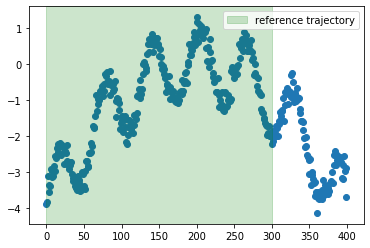

In [2]:
x = np.linspace(0, 40, 400).reshape((-1, 1))
y = np.sin(x) -(0.1*(x-20))**2 + randn(len(x)).reshape((-1, 1)) * 0.2
in_kern = SplitDimsKernel([0,1, 2], [PeriodicKernel(5, 1), GaussianKernel(0.5)])
out_kern = GaussianKernel(0.5)


pl.axvspan(0, 300, alpha=0.2, color="g", label="reference trajectory")
pl.scatter(np.arange(x.shape[0]),y.flatten())
pl.legend(loc="best")

In [3]:
spv = SpVec(in_kern, np.hstack((x, y)), np.array([len(x)]), use_subtrajectories = True)

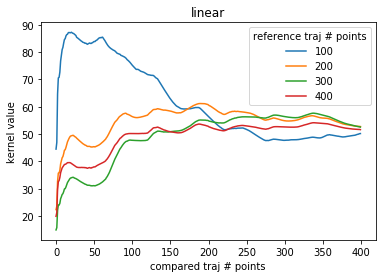

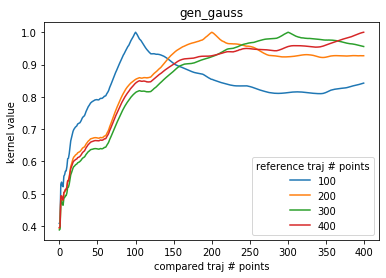

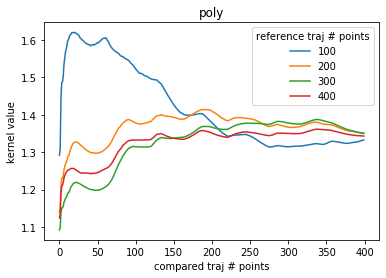

In [4]:
for dist in ("linear", "gen_gauss", "poly"):
    spv.use_inner = dist
    inn = spv.inner()
    pl.figure()
    for i in range(100, 401, 100):
        pl.plot(inn[i], label=str(i))
    pl.legend(loc="best", title="reference traj # points")
    pl.title(dist)
    pl.xlabel("compared traj # points")
    pl.ylabel("kernel value")

In [5]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)


In [6]:
refervec = FiniteVec(out_kern, np.linspace(y.min() - 4, y.max() + 4, 6000)[:, None])
invec_gg = SpVec(in_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="gen_gauss")
invec_lin = SpVec(in_kern,
                  np.hstack((x[:-1], y[:-1])),
                  np.array([len(x) - 1]),
                  use_subtrajectories = True,
                  use_inner="linear")
invec_pol = SpVec(in_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="poly")
outvec = FiniteVec(out_kern, y[1:])

Text(0.5, 1.0, 'Generalized gaussian kernel on process embeddings')

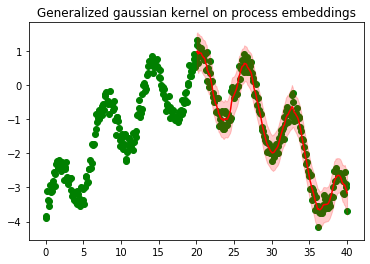

In [7]:
cd_gg = Cmo(invec_gg, outvec)
mean_var_gg = np.array((cd_gg @ invec_gg).normalized().get_mean_var()).T
plot_pred(mean_var_gg[199:], x, y)
pl.title("Generalized gaussian kernel on process embeddings")

Text(0.5, 1.0, 'Linear kernel on process embeddings')

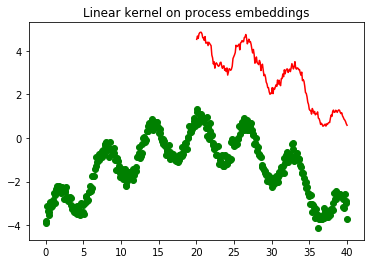

In [12]:
cd_lin = Cdo(invec_lin, outvec, refervec)
mean_var_lin = np.array((cd_lin @ invec_lin).normalized().get_mean_var()).T
plot_pred(mean_var_lin[199:], x, y)
pl.title("Linear kernel on process embeddings")

Text(0.5, 1.0, 'Polynomial kernel on process embeddings')

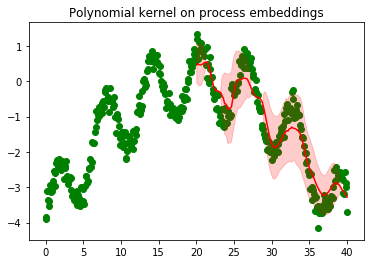

In [13]:
cd_pol = Cdo(invec_pol, outvec, refervec)
mean_var_pol = np.array((cd_pol @ invec_pol).normalized().get_mean_var()).T
plot_pred(mean_var_pol[199:], x, y)
pl.title("Polynomial kernel on process embeddings")

In [8]:
cmo_gg = Cmo(invec_gg, outvec)
cmo_lin = Cmo(invec_lin, outvec)
cmo_pol = Cmo(invec_pol, outvec)

In [9]:
import cProfile as profile


def rollout():
    samps = {}
    for (use_inner, cmo) in [ ("gen_gauss", cmo_gg), ("linear", cmo_lin),]:
        print("\n===", use_inner, "===\n\n")
        invec_inf = SpVec(in_kern, np.hstack((x[:200], y[:200])), np.array([200]), use_subtrajectories = False, use_inner=use_inner) #initial observed trajectory/warmup
        cur_ro = RolloutSpVec(cmo, invec_inf, 1)
        rval = []
        for i in tqdm(range(1, 400)):
            new_point = cur_ro.current_outp_emb.point_representant()
            rval.append(new_point)
            cur_ro.update(new_point)
        samps[use_inner] = rval
    return samps
pr = profile.Profile()
pr.enable()
samps = rollout()
pr.disable()


=== gen_gauss ===


100%|██████████| 399/399 [02:53<00:00,  2.30it/s]

=== linear ===


100%|██████████| 399/399 [00:16<00:00, 24.10it/s]


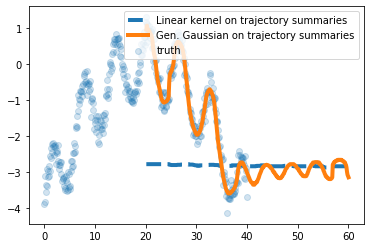

In [10]:
mdist = np.mean(x.flatten()[1:] - x.flatten()[:-1])
newlen = 200 + y.size
newx = np.arange(newlen) * mdist
#pl.plot(x.flatten()[200:],samps["poly"][:200], ".-", label = "poly")
#pl.fill_between(range(300), rv.mean(0)-rv.std(0), rv.mean(0)+rv.std(0), alpha=0.5)
pl.scatter(x.flatten(), y.flatten(), label="truth", alpha=0.2)
pl.plot(newx[201:], samps["linear"], "--", linewidth=4, label = "Linear kernel on trajectory summaries") 
pl.plot(newx[201:], samps["gen_gauss"], "", linewidth=4, label = "Gen. Gaussian on trajectory summaries")
pl.legend(loc="best")

0.84 635040000.0
100%|██████████| 123/123 [00:49<00:00,  2.50it/s]


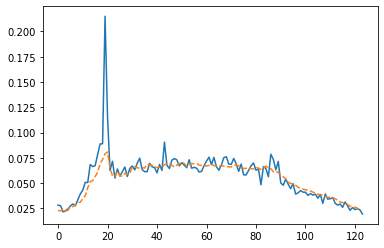

In [17]:
#overfit test
from data import Traffic
traf = Traffic()
idx_out = 20
n = 20

traf.data['train'] = Traffic.equalize_smp_size(traf.data['train']).values.reshape(-1, 144, traf.data['test'].shape[-1])
traf.data['test'] = traf.data['test'].values.reshape(-1, 144, traf.data['test'].shape[-1])

(train_inp, train_out) = (traf.data['train'][:idx_out, :-1, 1:3].reshape((-1, 2)),
                          traf.data['train'][:idx_out, 1:, 2:3].reshape((-1, 1)))
un, cts, sr = SparseReduce.sum_from_unique(train_out.flatten())
num_points_per_obs = 143
obs_median = 0.84 #0.9 #median_heuristic(traf.data['train'][:14, :-1, 2].reshape((-1, 1)), "sqeuclidean")
idx_median = 6.3504e+08 #1e+5 #median_heuristic(traf.data['train'][:14, :-1, 1:2].reshape((-1, 1)), "sqeuclidean")
print(obs_median, idx_median)

out_kern = GaussianKernel(obs_median)
period = traf.data['train'][idx_out:idx_out+1, :, 1:2].max()
idx_kern = PeriodicKernel(period, 1)
#idx_kern = GaussianKernel(idx_median)
in_kern = SplitDimsKernel([0, 1, 2], [idx_kern, out_kern])

inp_vec = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs)
out_vec = FiniteVec(out_kern, train_out) #FiniteVec(out_kern, un[:, np.newaxis],)

O = Cmo(inp_vec, out_vec)
len(sr.idcs), un.shape



test_inp = traf.data['train'][idx_out:idx_out+1, :n, 1:3].reshape((-1, 2))
#test_inp[:, 1:] = stats.norm.ppf(to.cdf(test_inp[:, 1:]))
test_out = traf.data['train'][idx_out:idx_out+1, n:, 2:3]
#test_out = stats.norm.ppf(to.cdf(traf.data['train'][idx_out, n:, 2:3]))

inp_test = SpVec(in_kern, test_inp, np.array([n]), use_subtrajectories = False)
cur_ro = RolloutSpVec(O, inp_test, 1)
rval = []
for i in tqdm(range(1, 144-n)):
    new_point = cur_ro.current_outp_emb.point_representant()
    rval.append(new_point)
    cur_ro.update(new_point)
s = np.array(rval)
pl.plot(test_out.squeeze())
pl.plot(s, "--")